# 4 Users segmentation

For the sentiment analysis of the Amazon Fine Foods Review dataset I use pretrained bidirectional transformer [BERT](https://huggingface.co/transformers/model_doc/bert.html). The model was fine tuned using 80% training subset of the dataset. Th rest 20% validation subset will be used for the sentiment analysis, since it is relatively large (almost 79k samples). The validation subset has not used for the training steps and will not introduce train/serve skew due to possible overfitting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib as mpl
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

sns.set(font_scale=2)
plt.style.use('seaborn-white')
%matplotlib inline

## 4.1 Reproducing Validation set
The data analysis performed for the current project will use only validation subset of the initial dataset.
The validation subset with over 75k rows is large enough for general analysis of the dataset.
Since it has not been used neither for model training nor for tuning the model meta parameters,
it should give results similar to real serving case. I split the dataset into train (80% samples) and validation (20%) sets exactly the same way as it have been don in the training step. For users segmentation I will use the dataset including original dataset data as well as results of the model predictions. Without additional weight/embeddings extraction from the BERT model the users can be classified using few-dimensional embedding space. The initial dimensions could be *Label*, *TextPred*, *SumPred*, and possibly *HelpfulnessNumerator/HelpfulnessDenominator*. 

Loading clean and deduplicated dataset:

In [2]:
df_dedup = pd.read_csv("./ReviewsDedupLowNT.csv.zip",
                       compression="zip", index_col=0)

Transforming review score to 0-based: from 1-5 stars to 0-4 label and rename column for clarity:

In [3]:
df_dedup["Score"] = df_dedup["Score"] - 1
df_dedup.rename(columns={"Score": "Label"}, inplace=True)
df_dedup.tail(5)

,Text,Summary,Label,UserId,HelpfulnessNumerator,HelpfulnessDenominator
395003,these are sooooooooooooooooooooooooo delicious...,"yummy. yummy, yummy!",4,A2FOR1IJSX76LQ,0,3
395004,this is a for the price of review because p...,pure chocolate mallomars cookies,3,A26UNIPEVYE9DE,0,0
395005,this would be a great coffee drink to grab out...,soso espresso style coffee drink,2,A26UNIPEVYE9DE,1,2
395006,"earths best infant formula soy iron,ounce is a...",earths best soy baby formula,4,A2CEDG8O4AYV8K,0,0
395007,taste. i was expecting it to taste pretty clos...,ehh okay i guess.,1,A1FP825HKFI0T0,1,1


In [4]:
df_train = df_dedup.sample(frac=0.8,random_state=123)
df_test = df_dedup.drop(df_train.index)
df_test.reset_index(inplace=True)
df_test.tail()

,index,Text,Summary,Label,UserId,HelpfulnessNumerator,HelpfulnessDenominator
78970,394995,"yummyyyy!very flavourful and easy to make, but...",yummy,4,A2P3TGJU301KXD,0,1
78971,394997,zico probably has the best taste of the coconu...,great tasting,4,A13RF7W3A98FS0,0,0
78972,394999,zzzzzzz. i had high hopes for this coffee and ...,caffeen addicts need not apply,0,A20CTKKZEQGD3E,1,2
78973,395002,"quick take tasty, chewy, softbaked cookies wi...",quaker soft baked oatmeal cookies,4,AES9VNGFZLOE1,1,2
78974,395005,this would be a great coffee drink to grab out...,soso espresso style coffee drink,2,A26UNIPEVYE9DE,1,2


In [5]:
text_predictions = pd.read_csv("./PredVa79ke3x3.csv.zip",
                               index_col=0, compression="zip")
sum_predictions = pd.read_csv("./PredSumVa79ke3x3.csv.zip",
                              index_col=0, compression="zip")

## 4.2 Multidimensional sentiment analysis

Since the task is segmentation of users (not reviews), the reviews dataset will be aggregated with respect to *UserId*.

In [6]:
df_segm = pd.concat([df_test, text_predictions["0"], sum_predictions["0"]],
                    axis=1, join="inner")
df_segm.columns = ["OrigIndex", "Text", "Summary", "Label", "UserId",
                   "HelpfulnessNumerator", "HelpfulnessDenominator",
                   "TextPred", "SumPred"]

In [7]:
df_segm.tail()

,OrigIndex,Text,Summary,Label,UserId,HelpfulnessNumerator,HelpfulnessDenominator,TextPred,SumPred
78970,394995,"yummyyyy!very flavourful and easy to make, but...",yummy,4,A2P3TGJU301KXD,0,1,4,4
78971,394997,zico probably has the best taste of the coconu...,great tasting,4,A13RF7W3A98FS0,0,0,4,4
78972,394999,zzzzzzz. i had high hopes for this coffee and ...,caffeen addicts need not apply,0,A20CTKKZEQGD3E,1,2,0,4
78973,395002,"quick take tasty, chewy, softbaked cookies wi...",quaker soft baked oatmeal cookies,4,AES9VNGFZLOE1,1,2,4,4
78974,395005,this would be a great coffee drink to grab out...,soso espresso style coffee drink,2,A26UNIPEVYE9DE,1,2,3,4


The *Label*, *TextPred* and *SumPred* values will be averaged over all reviews from each user:

In [8]:
avg_user_scores = {
    c: "first" if c == "UserId"
    else "mean" for c in ["Label", "TextPred", "SumPred"]}

In [9]:
df_usr = df_segm.groupby(["UserId"]).agg(avg_user_scores)

In [10]:
len(df_usr)

65149

For the clustering approach the dataset size will be limited to 30000 points due to memory issues.

In [11]:
X = df_segm[0:30000].as_matrix(columns=df_usr.columns[[0,1,2]])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [12]:
clustering = DBSCAN(eps=0.7, min_samples=800).fit(X)

results of the clustering procedure:

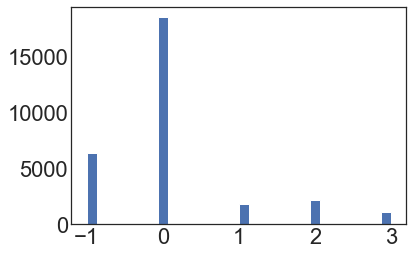

In [13]:
plt.show(plt.hist(clustering.labels_, bins=30))
#unique, counts = np.unique(
#    clustering.labels_, return_counts=True)
#np.asarray((unique, counts)).T

Now the clusterized data can be plotted in the (*Label*, *TextPred*, *SumPred*) phase space. In order to make the plot more informative and mitigate issues of discrete phase space a small jitter will be added to the data points:

In [14]:
def add_jitter(column, amplitude):
    column = column + amplitude * (np.random.rand(len(column)) - 0.5)
    return(column)

In [15]:
df_usr_jit = df_usr.copy()
df_usr_jit = df_usr_jit.reset_index()
df_usr_jit = pd.concat([df_usr_jit, pd.Series(clustering.labels_)],axis=1, join="inner")
df_usr_jit.columns = ["UserId", "Label", "TextPred", "SumPred", "ClusterNr"]

df_usr_jit["Label"] = add_jitter(df_usr_jit["Label"], 0.3) 
df_usr_jit["TextPred"] = add_jitter(df_usr_jit["TextPred"], 0.3) 
df_usr_jit["SumPred"] = add_jitter(df_usr_jit["SumPred"], 0.3) 

In [16]:
df_usr_jit.tail()

,UserId,Label,TextPred,SumPred,ClusterNr
29995,A2QVQTS0APTRAQ,3.078928,4.063225,4.147500,0
29996,A2QVRNNE3SO2WX,4.054259,3.875778,3.897399,2
29997,A2QVS0S0KA0B7,3.941521,4.007328,3.909730,0
29998,A2QVU8G8ZPPW7V,0.109887,0.081730,0.914298,0
29999,A2QW07MTFS999V,1.982063,1.918261,-0.070518,2


Now one can plot 3d scatter plot with color characterizing number of cluster:

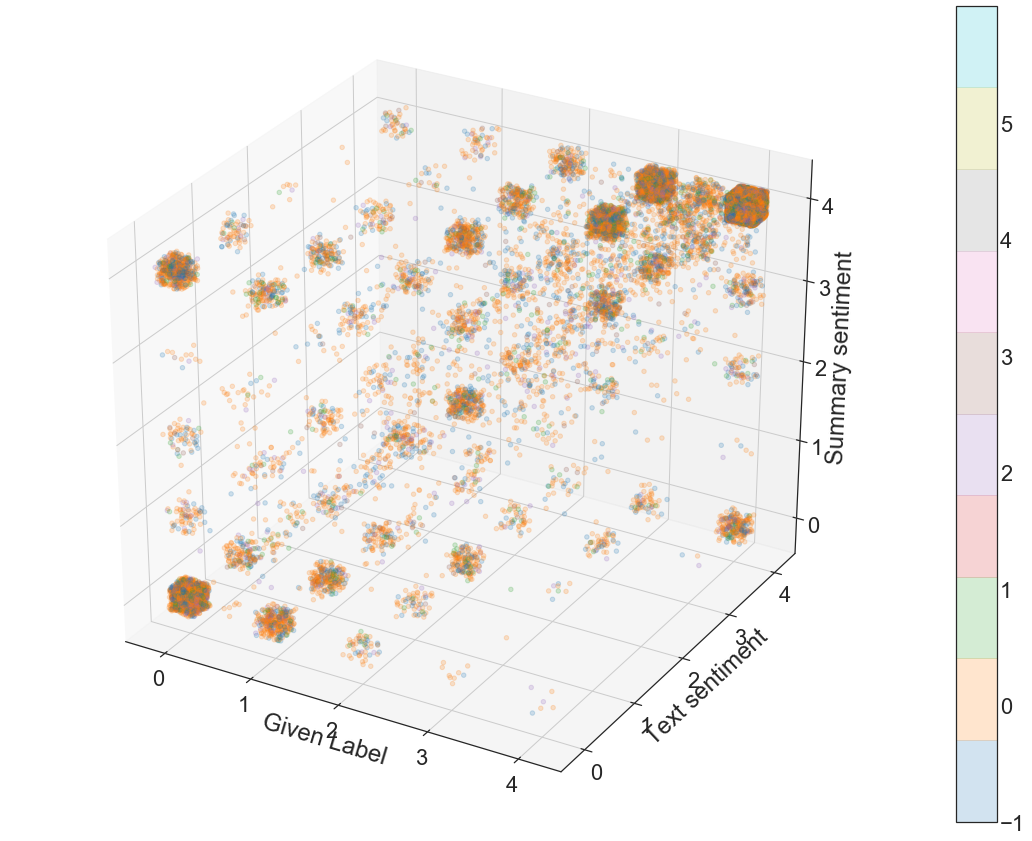

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['figure.figsize'] = [20, 15]

scatter = ax.scatter(df_usr_jit["Label"],
           df_usr_jit["TextPred"],
           df_usr_jit["SumPred"],
           c=df_usr_jit["ClusterNr"],
           cmap = mpl.cm.get_cmap("tab10"), vmin=-1, vmax=max(clustering.labels_)+1,
                    alpha=0.2)

plt.colorbar(scatter, ticks=np.arange(-1, max(clustering.labels_)+1))

ax.set_xlabel("Given Label")
ax.set_ylabel("Text sentiment")
ax.set_zlabel("Summary sentiment")

plt.show()

The figure shows visible correlation between given *Label* and sentiment prediction, similar to confusion matrices from Chapters 3.1 and 3.2. However division of points into clusters cannot be observed, the dominating class 0 is spreaded along all phase space. Let's remove class 0 (dominating) and class -1 (non-classified) form the figure and take a look on the rest:

In [18]:
df_usr_jit_no_m1_0 = df_usr_jit.copy()
df_usr_jit_no_m1_0 = df_usr_jit_no_m1_0[
    (df_usr_jit_no_m1_0["ClusterNr"]!=-1)&(df_usr_jit_no_m1_0["ClusterNr"]!=0)]
df_usr_jit_no_m1_0.reset_index(inplace=True)

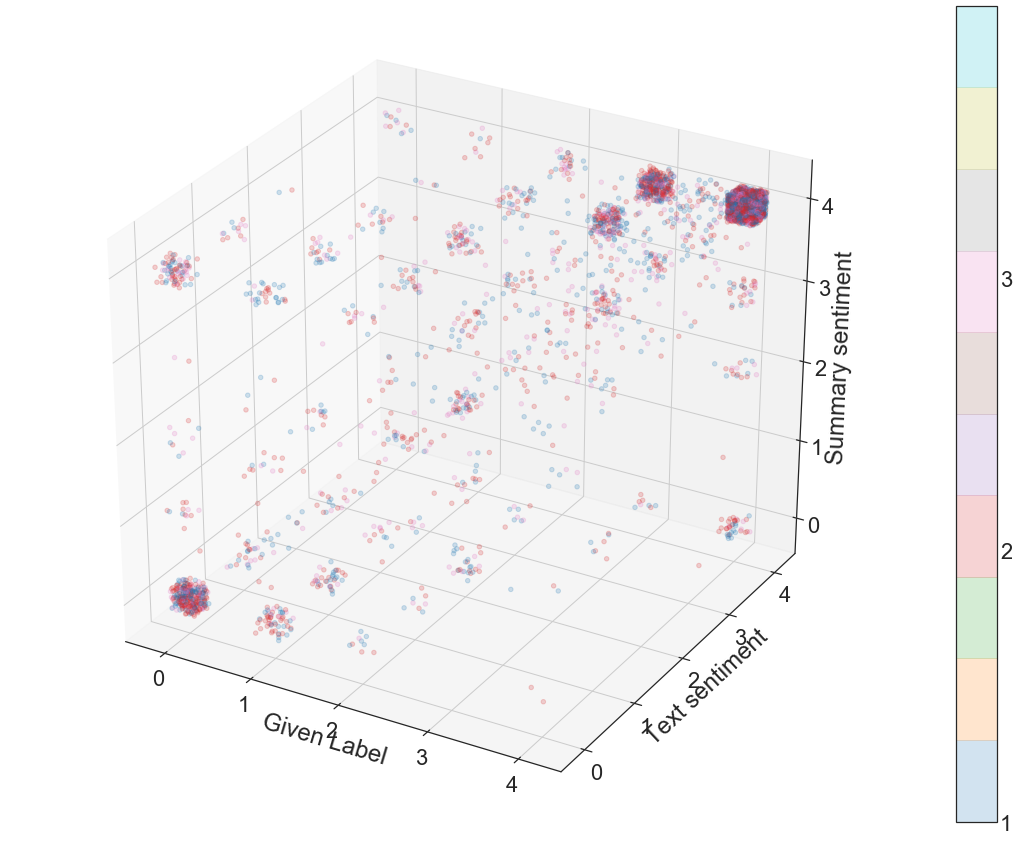

In [19]:
fig = plt.figure()
plt.rcParams['figure.figsize'] = [20, 15]
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(df_usr_jit_no_m1_0["Label"],
           df_usr_jit_no_m1_0["TextPred"],
           df_usr_jit_no_m1_0["SumPred"],
           c=df_usr_jit_no_m1_0["ClusterNr"],
           cmap = mpl.cm.get_cmap("tab10"), vmin=1, vmax=max(clustering.labels_)+1,
                    alpha=0.2)

plt.colorbar(scatter, ticks=np.arange(-1, max(clustering.labels_)+1))

ax.set_xlabel("Given Label")
ax.set_ylabel("Text sentiment")
ax.set_zlabel("Summary sentiment")

plt.show()

The situation does not become clearer, all classes are spreaded along the phase space.
A number of runs of DBSCAN clustering with different parameters (*eps*, *min_samples*) have been performed,
however no visible clusterisation in the considered phase space observed.

## 4.3 Analysis of users with multiple reviews

Since clusterization of unsorted individual users was unsuccessful, let's try to improve quality
of the input data. First filter initial dataset leaving only users who have at least 5 reviews. Let's determine number of such users in the validation subset, for which we have sentiment predictions: 

In [20]:
usr_gt5_mask = (df_segm.groupby(["UserId"]).UserId.count().sort_values(ascending=False)>5)
usr_gt5_mask.sum()

510

Now get list with these *UserId*:

In [21]:
usr_gt5 = (usr_gt5_mask[usr_gt5_mask].index).tolist()

Next all reviews of these users can be extracted:

In [22]:
df_segm_gt_5 = df_segm[df_segm["UserId"].isin(usr_gt5)]
df_segm_gt_5 = df_segm_gt_5.reset_index()

In [23]:
len(df_segm_gt_5["UserId"].unique())

510

And aggregated in order to get some information about users based on statistics of their reviews: 

In [24]:
user_stats = {
    c: "first" if c == "UserId"
    else ["mean", "std"] for c in ["Label", "TextPred", "SumPred"]}
df_usr_gt_5 = df_segm_gt_5.groupby(["UserId"]).agg(user_stats)
df_usr_gt_5.head()

Label            TextPred             SumPred          
                    mean       std      mean       std      mean       std
UserId                                                                    
A100WO06OQR8BQ  3.000000  1.224745  3.111111  1.452966  2.777778  1.563472
A1080SE9X3ECK0  3.571429  1.089410  3.571429  1.089410  3.714286  1.069045
A10DRHWKS6NQUX  2.750000  1.581139  2.750000  1.388730  3.375000  1.407886
A10PEXB6XAQ5XF  3.333333  0.816497  3.666667  0.816497  3.833333  0.408248
A11ED8O95W2103  3.000000  0.894427  3.181818  0.873863  3.636364  0.674200

Analysing the properties of obtained dataset one can find relatively smooth distributions of the data:

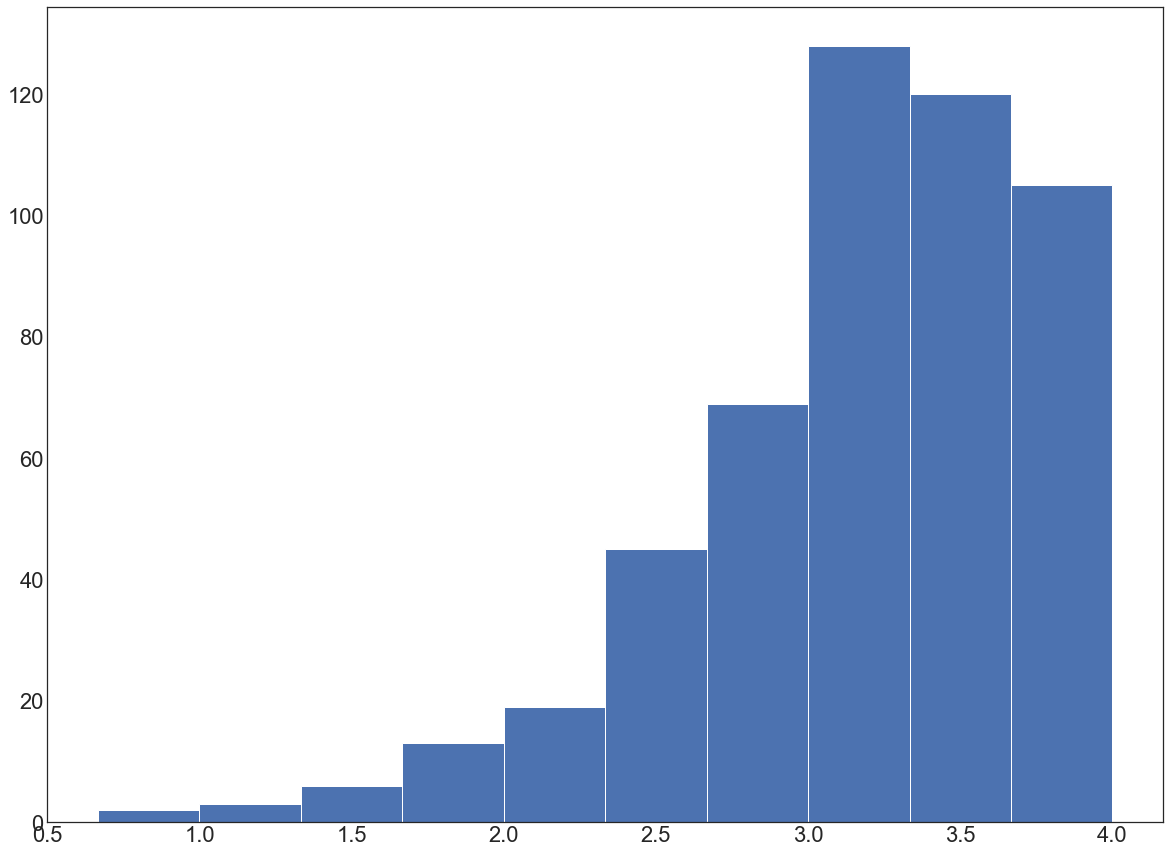

In [25]:
plt.hist(df_usr_gt_5["Label"]["mean"]);

In [26]:
X_gt5 = df_usr_gt_5.as_matrix(
    columns=df_usr_gt_5.columns[[0,1,2,3,4,5]])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


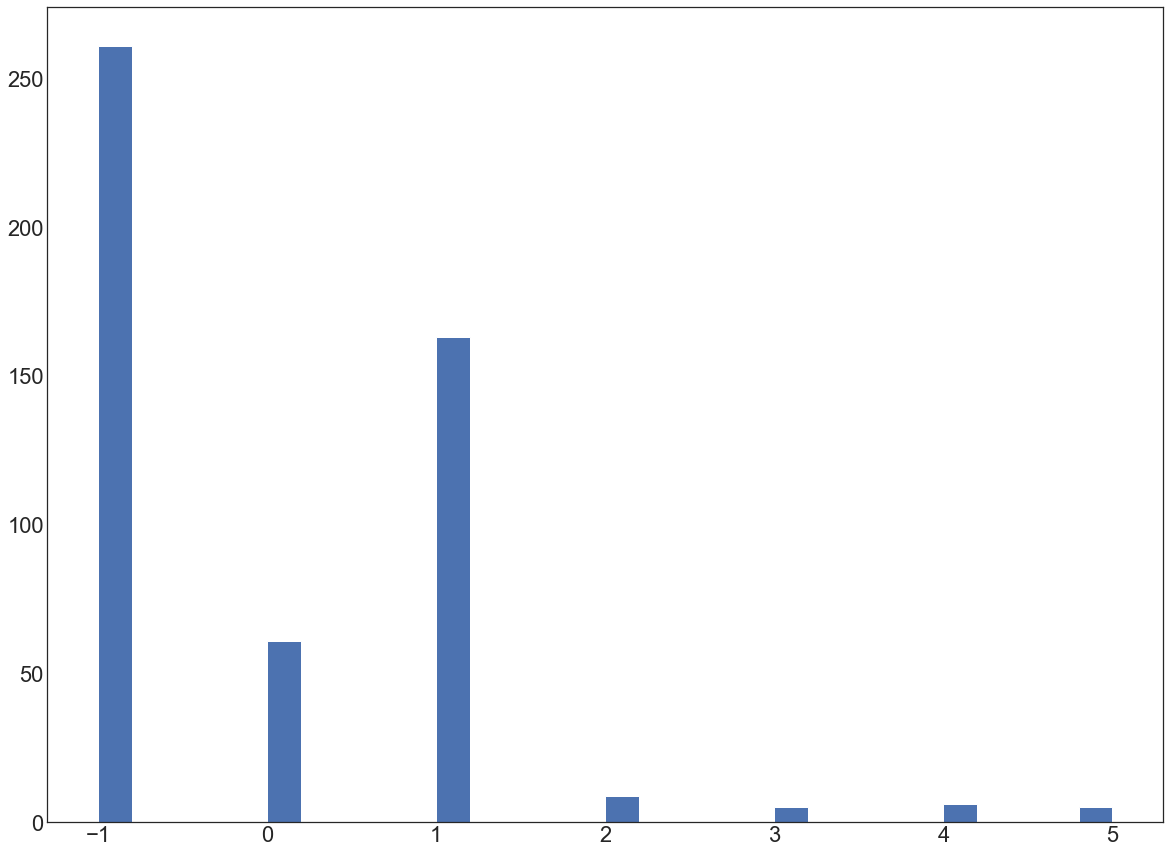

In [27]:
clustering = DBSCAN(eps=0.3, min_samples=5).fit(X_gt5)
plt.show(plt.hist(clustering.labels_, bins=30))

Now let's plot 3d scatter plot with color characterizing number of cluster:

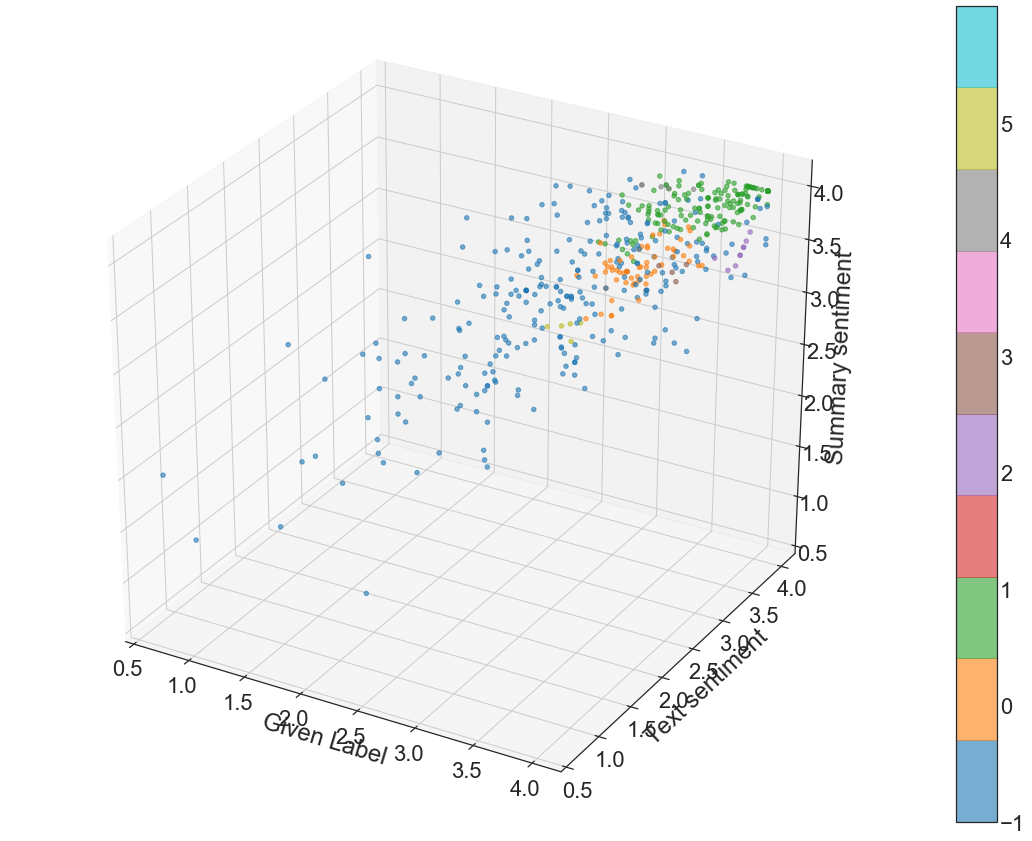

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['figure.figsize'] = [20, 15]

scatter = ax.scatter(df_usr_gt_5["Label"]["mean"],
           df_usr_gt_5["TextPred"]["mean"],
           df_usr_gt_5["SumPred"]["mean"],
           c=clustering.labels_,
           cmap = mpl.cm.get_cmap("tab10"), vmin=-1, vmax=max(clustering.labels_)+1,
                    alpha=0.6)

plt.colorbar(scatter, ticks=np.arange(-1, max(clustering.labels_)+1))

ax.set_xlabel("Given Label")
ax.set_ylabel("Text sentiment")
ax.set_zlabel("Summary sentiment")

plt.show()

On the figure above one can clearly distinguish clusters of users:

- non-classified (class -1) as blue dots scattered over phase space
- class 0 (orange) in 3.0 - 3.5 sentiment range
- class 1 (green) around highest sentiment 4.0 
- class 5 (dark green) in 3.0 - 3.5 sentiment range

Also this figure shows good correlation between *Score* (given label) and sentiment predictions by BERT model. 

## 4.4 Users segmentation summary

The DBSCAN approach used in this chapter found to be sensitive to data quality.
In order to solve the users segmentation problem based on the sentiment analysis more efficient way,
two approaches can be used:

(i) Get sample weights from the embedding layer of the BERT model and use it as multidimensional input for another DNN classifier, possibly combining this information with *HelpfulnessNumerator* and *HelpfulnessDenominator* human feedback

(ii) Try using optimized low-dimensional embedded space, performing basis transformations (e.g. PCA) or generating statistically-based features. 